<a href="https://colab.research.google.com/github/wendianaxu/speech-emotion-recognition/blob/main/training_2d_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import librosa
import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/wendianaxu/speech-emotion-recognition.git

Cloning into 'speech-emotion-recognition'...
remote: Enumerating objects: 1525, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 1525 (delta 22), reused 31 (delta 9), pack-reused 1469
Receiving objects: 100% (1525/1525), 213.92 MiB | 16.28 MiB/s, done.
Resolving deltas: 100% (261/261), done.
Updating files: 100% (1445/1445), done.


In [ ]:
# copy directory to drive
!cp -r "/content/speech-emotion-recognition" "/content/drive/MyDrive"

In [16]:
# test: load an audio file, extract mfccs, and visualize

test_file = "/content/drive/MyDrive/speech-emotion-recognition/RAVDESS_data/Actor_01/03-01-01-01-01-02-01.wav"
n_mfcc = 30
sr = 22050 # sampling rate


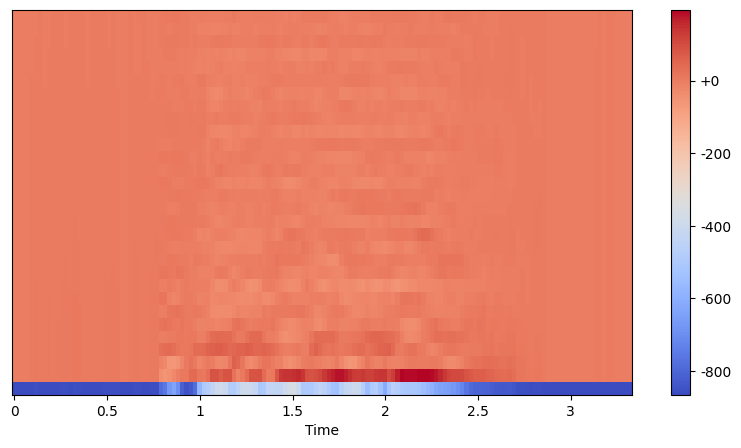

In [17]:
# visualize mfccs
audio, sampling_rate = librosa.load(test_file, sr=sr, duration=None)
test_mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)

plt.figure(figsize=(10, 5))
librosa.display.specshow(test_mfccs, 
                         x_axis="time", 
                         sr=sr)
plt.colorbar(format="%+2.f")
plt.show()

In [25]:
# function for loading an audio file
data_path = "/content/drive/MyDrive/speech-emotion-recognition/RAVDESS_data/"
def load_file(path):
  '''
  Load one audio file and return a 1D array containing its mfccs averaged across time
  '''
  audio, sampling_rate = librosa.load(path, sr=sr, duration=None)
  # trim out silent moments from the audio
  audio, index = librosa.effects.trim(audio, top_db=20, frame_length=512, hop_length=512)
  mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc) # extract MFCC matrix (cols = coefficients, rows = time)

  # unify sizes

  return mfccs

load_file(test_file).shape

(30, 53)

In [22]:
# find out the max time length of trimmed audio files
def find_max_len(path):
  max_len = 0 # max duration of trimmed data
  for folder in os.listdir(path): # each folder = one actor
      for file in os.listdir(os.path.join(path, folder)):
          if file.endswith('.wav'):
              file_path = os.path.join(path, folder, file)
              features = load_file(file_path)
              features_len = features.shape[1]
              if max_len < features_len:
                max_len = features_len
  return max_len

In [21]:
max_len = find_max_len(data_path)
max_len

144

In [31]:
# redefine load_file() so that all feature matrices have the size (n_mfccs, max_len)
def load_file(path):
  '''
  Load one audio file and return a 1D array containing its mfccs averaged across time
  '''
  audio, sampling_rate = librosa.load(path, sr=sr, duration=None)
  # trim out silent moments from the audio
  audio, index = librosa.effects.trim(audio, top_db=20, frame_length=512, hop_length=512)
  mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc) # extract MFCC matrix (cols = coefficients, rows = time)

  # unify sizes
  if max_len > mfccs.shape[1]: # pad matrices that are shorter than max_len
    pad_width = max_len - mfccs.shape[1]
    mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')

  return mfccs

In [33]:
def preprocess_data(path):
  '''
  Preprocess data in all folders within the dataset. 
  '''
  X = []
  y = []
  for folder in os.listdir(path): # each folder = one actor
      for file in os.listdir(os.path.join(path, folder)):
          if file.endswith('.wav'):
              emotion = file.split('-')[2] # get emotion label
              if int(emotion) == 1:
                  label = 'Neutral'
              elif int(emotion) == 2:
                  label = 'Calm'
              elif int(emotion) == 3:
                  label = 'Happy'
              elif int(emotion) == 4:
                  label = 'Sad'
              elif int(emotion) == 5:
                  label = 'Angry'
              elif int(emotion) == 6:
                  label = 'Fearful'
              elif int(emotion) == 7:
                  label = 'Disgust'
              elif int(emotion) == 8:
                  label = 'Surprised'
              else:
                  label = 'UNK'
                  
              file_path = os.path.join(path, folder, file)
              features = load_file(file_path)
              X.append(features)
              y.append(label)
  return np.array(X), np.array(y)

In [34]:
X, y = preprocess_data(data_path)
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (1440, 30, 144)
Shape of y: (1440,)


In [35]:
# one-hot encode labels
from sklearn.preprocessing import OneHotEncoder
OHE = OneHotEncoder()

y = np.array(y).reshape(-1,1)
y = OHE.fit_transform(y).toarray()

In [36]:
# save X, y
np.save('/content/drive/MyDrive/speech-emotion-recognition/X_2d.npy', X)
np.save('/content/drive/MyDrive/speech-emotion-recognition/y.npy', y)

In [88]:
# load X, y
X = np.load('/content/drive/MyDrive/speech-emotion-recognition/X_2d.npy')
y = np.load('/content/drive/MyDrive/speech-emotion-recognition/y.npy')
print(X.shape, y.shape)

(1440, 30, 144) (1440, 8)


In [89]:
# train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

In [39]:
# CNN with torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
from torchsummary import summary
import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [90]:
# transform preprocessed data to Dataset class
from torch.utils.data import TensorDataset, DataLoader
from torch import Tensor

# transform arrays to torch tensors
X_train = Tensor(X_train).unsqueeze(1) # add channel = 1
y_train = Tensor(y_train)
X_test = Tensor(X_test).unsqueeze(1) # add channel = 1
y_test = Tensor(y_test)

train_set = TensorDataset(X_train, y_train) 
test_set = TensorDataset(X_test, y_test) 


In [91]:
X_train.shape

torch.Size([1152, 1, 30, 144])

In [93]:
# create DataLoaders
batch_size = 16

train_loader = DataLoader(train_set, batch_size = batch_size, 
                          shuffle = True, num_workers = 2)
test_loader = DataLoader(test_set, batch_size = batch_size, 
                          shuffle = True, num_workers = 2)

In [94]:
X, y = next(iter(train_loader))
print(X.shape, y.shape) 

torch.Size([16, 1, 30, 144]) torch.Size([16, 8])


In [50]:
# training loop
import torch.optim as optim

def train(model, k_epochs = 1, print_every = 20):

    loss_fn = nn.CrossEntropyLoss() 
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    correct, total = 0, 0

    for epoch in range(k_epochs): 

        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):

            # extract a batch of training data from the data loader
            X, y = data
            X = X.to(device)
            y = y.to(device)

            # zero out gradients: we're going to recompute them in a moment
            optimizer.zero_grad()

            # compute the loss (forward pass)
            y_hat = model(X)
            loss = loss_fn(y_hat, y)

            # compute the gradient (backward pass)
            loss.backward()

            # Adam uses the gradient to update the parameters
            optimizer.step()

            # print statistics
            running_loss += loss.item()

            # for printing accuracy
            total += y.size(0)
            correct += (torch.argmax(y_hat, dim=1) == torch.argmax(y, dim=1)).sum().item()

            # print the epoch, number of batches processed, and running loss 
            # in regular intervals
            if i % print_every == print_every - 1:    
              print(f'[epoch: {epoch + 1}, batches: {i + 1:5d}], loss: {running_loss / print_every:.3f}, accuracy:{correct/total:.3f}')
              running_loss = 0.0

    print('Finished Training')



In [51]:
# testing loop
def test(model, data_loader):
    correct = 0
    total = 0
    # torch.no_grad creates an environment in which we do NOT store the 
    # computational graph. We don't need to do this because we don't care about 
    # gradients unless we're training
    with torch.no_grad():
        for data in data_loader:
            X, y = data
            X = X.to(device)
            y = y.to(device)
            
            # run all the images through the model
            y_hat = model(X)

            # the class with the largest model output is the prediction
            predicted = torch.argmax(y_hat, dim=1)

            # compute the accuracy
            total += y.size(0)
            correct += (predicted == torch.argmax(y, dim=1)).sum().item()

    print(f'Test accuracy: {100 * correct // total} %')


In [105]:
# model1
class ConvNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(1, 128, kernel_size=3)
    self.bn1 = nn.BatchNorm2d(128)
    self.conv2 = nn.Conv2d(128, 64, kernel_size=3)
    self.bn2 = nn.BatchNorm2d(64)
    self.pool = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(64 * 204, 32)
    self.fc2 = nn.Linear(32, 8)
  
  def forward(self, x):
    x = self.pool(F.relu(self.bn1(self.conv1(x))))
    x = self.pool(F.relu(self.bn2(self.conv2(x))))
    x = x.view(x.size(0), -1)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

model1 = ConvNet().to(device)

In [106]:
# train model1
train(model1, k_epochs = 50)

[epoch: 1, batches:    20], loss: 2.376, accuracy:0.122
[epoch: 1, batches:    40], loss: 2.060, accuracy:0.127
[epoch: 1, batches:    60], loss: 2.063, accuracy:0.133
[epoch: 2, batches:    20], loss: 2.041, accuracy:0.150
[epoch: 2, batches:    40], loss: 2.035, accuracy:0.150
[epoch: 2, batches:    60], loss: 2.025, accuracy:0.148
[epoch: 3, batches:    20], loss: 1.922, accuracy:0.144
[epoch: 3, batches:    40], loss: 1.899, accuracy:0.148
[epoch: 3, batches:    60], loss: 1.877, accuracy:0.153
[epoch: 4, batches:    20], loss: 1.775, accuracy:0.164
[epoch: 4, batches:    40], loss: 1.854, accuracy:0.167
[epoch: 4, batches:    60], loss: 1.800, accuracy:0.173
[epoch: 5, batches:    20], loss: 1.683, accuracy:0.184
[epoch: 5, batches:    40], loss: 1.676, accuracy:0.192
[epoch: 5, batches:    60], loss: 1.686, accuracy:0.201
[epoch: 6, batches:    20], loss: 1.541, accuracy:0.218
[epoch: 6, batches:    40], loss: 1.530, accuracy:0.226
[epoch: 6, batches:    60], loss: 1.530, accurac

In [109]:
# test model1
test(model1, test_loader)

Test accuracy: 54 %


In [110]:
# model2: with dropout
class ConvNet(nn.Module):
  def __init__(self, dropout_prob = 0.5):
    super().__init__()

    self.conv1 = nn.Conv2d(1, 128, kernel_size=3)
    self.bn1 = nn.BatchNorm2d(128)
    self.conv2 = nn.Conv2d(128, 64, kernel_size=3)
    self.bn2 = nn.BatchNorm2d(64)
    self.dropout = nn.Dropout(dropout_prob)
    self.pool = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(64 * 204, 32)
    self.fc2 = nn.Linear(32, 8)
  
  def forward(self, x):
    x = self.pool(F.relu(self.bn1(self.conv1(x))))
    x = self.dropout(x)
    x = self.pool(F.relu(self.bn2(self.conv2(x))))
    x = self.dropout(x)
    x = x.view(x.size(0), -1)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

model2 = ConvNet().to(device)

In [111]:
train(model2, k_epochs = 50)

[epoch: 1, batches:    20], loss: 2.076, accuracy:0.191
[epoch: 1, batches:    40], loss: 1.993, accuracy:0.222
[epoch: 1, batches:    60], loss: 1.917, accuracy:0.240
[epoch: 2, batches:    20], loss: 1.769, accuracy:0.262
[epoch: 2, batches:    40], loss: 1.675, accuracy:0.279
[epoch: 2, batches:    60], loss: 1.774, accuracy:0.283
[epoch: 3, batches:    20], loss: 1.596, accuracy:0.303
[epoch: 3, batches:    40], loss: 1.556, accuracy:0.316
[epoch: 3, batches:    60], loss: 1.570, accuracy:0.324
[epoch: 4, batches:    20], loss: 1.418, accuracy:0.348
[epoch: 4, batches:    40], loss: 1.366, accuracy:0.356
[epoch: 4, batches:    60], loss: 1.479, accuracy:0.362
[epoch: 5, batches:    20], loss: 1.360, accuracy:0.374
[epoch: 5, batches:    40], loss: 1.359, accuracy:0.382
[epoch: 5, batches:    60], loss: 1.317, accuracy:0.388
[epoch: 6, batches:    20], loss: 1.154, accuracy:0.402
[epoch: 6, batches:    40], loss: 1.314, accuracy:0.407
[epoch: 6, batches:    60], loss: 1.179, accurac

In [116]:
test(model2, test_loader)

Test accuracy: 54 %


In [128]:
# model3
class ConvNet(nn.Module):
  def __init__(self, dropout_prob = 0.5):
    super().__init__()

    self.conv1 = nn.Conv2d(1, 64, kernel_size=3)
    self.bn1 = nn.BatchNorm2d(64)
    self.conv2 = nn.Conv2d(64, 32, kernel_size=3)
    self.bn2 = nn.BatchNorm2d(32)
    self.dropout = nn.Dropout(dropout_prob)
    self.pool = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(64 * 102, 128)
    self.fc2 = nn.Linear(128, 8)
  
  def forward(self, x):
    x = self.pool(F.relu(self.bn1(self.conv1(x))))
    x = self.dropout(x)
    x = self.pool(F.relu(self.bn2(self.conv2(x))))
    x = self.dropout(x)
    x = x.view(x.size(0), -1)
    x = F.relu(self.fc1(x))

    x = self.fc2(x)
    return x

model3 = ConvNet().to(device)

In [129]:
train(model3, k_epochs = 50)

[epoch: 1, batches:    20], loss: 2.280, accuracy:0.153
[epoch: 1, batches:    40], loss: 1.945, accuracy:0.188
[epoch: 1, batches:    60], loss: 1.820, accuracy:0.212
[epoch: 2, batches:    20], loss: 1.768, accuracy:0.237
[epoch: 2, batches:    40], loss: 1.650, accuracy:0.258
[epoch: 2, batches:    60], loss: 1.704, accuracy:0.268
[epoch: 3, batches:    20], loss: 1.577, accuracy:0.291
[epoch: 3, batches:    40], loss: 1.526, accuracy:0.300
[epoch: 3, batches:    60], loss: 1.562, accuracy:0.311
[epoch: 4, batches:    20], loss: 1.433, accuracy:0.327
[epoch: 4, batches:    40], loss: 1.513, accuracy:0.336
[epoch: 4, batches:    60], loss: 1.380, accuracy:0.344
[epoch: 5, batches:    20], loss: 1.399, accuracy:0.355
[epoch: 5, batches:    40], loss: 1.369, accuracy:0.363
[epoch: 5, batches:    60], loss: 1.271, accuracy:0.372
[epoch: 6, batches:    20], loss: 1.269, accuracy:0.386
[epoch: 6, batches:    40], loss: 1.183, accuracy:0.393
[epoch: 6, batches:    60], loss: 1.266, accurac

In [141]:
test(model3, test_loader)

Test accuracy: 57 %
